# Supercompressible: classification 3d

This notebook intends to show the application of classification to make predictions about the coilability in the supercompressible example.

So, let's start by importing the required libraries:

In [1]:
# standard library
import pickle
import itertools

# third-party
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
binary_metrics = ((accuracy_score, 'Accuracy score'),
                  (f1_score, 'F1 score'),
                  (precision_score, 'Precision score'),
                  (recall_score, 'Recall score'))

In [3]:
colors = ['r', 'g', 'b']

Now, let's import the data.

In [4]:
# get pandas frame
filename = 'DoE_results.pkl'
with open(filename, 'rb') as file:
    data = pickle.load(file)
    
# define number of points to start with
N = 10000

points = data['points'].loc[:(N-1)]
print('variables:', [col for col in points.columns])

# get number of inputs
n_inputs = len(points.columns) - 3

# get X data
X = points.iloc[:,range(n_inputs)].values.copy()

# get y data
var_name = 'coilable'
y = points.loc[:, var_name].values.copy()

print('X:', X)
print('X shape:', np.shape(X))
print('y:', y)
print('y shape:', np.shape(y))

variables: ['ratio_d', 'ratio_pitch', 'ratio_top_diameter', 'coilable', 'sigma_crit', 'energy']
X: [[0.004      0.25       0.        ]
 [0.0385     0.875      0.4       ]
 [0.05575    0.5625     0.2       ]
 ...
 [0.06037836 1.08930969 0.58618164]
 [0.04312836 0.77680969 0.38618164]
 [0.00862836 1.40180969 0.78618164]]
X shape: (10000, 3)
y: [1. 0. 2. ... 0. 2. 0.]
y shape: (10000,)


Since it is a classification problem, let's see how balanced the classes are.

In [5]:
for yy in np.unique(y):
    print('Class %i: %i' % (int(yy), np.sum(y==yy)))

Class 0: 3174
Class 1: 2013
Class 2: 4813


Let's create a function to split the data and evaluate the results.

In [6]:
def split_data(X, y, train_size):
    
    # split data
    test_size = 1 - train_size
    indices = range(len(y))
    X_train = X[indices[:-int(round(len(indices) * test_size))]]
    X_test = X[indices[-int(round(len(indices) * test_size)):]]
    y_train = y[indices[:-int(round(len(indices) * test_size))]]
    y_test = y[indices[-int(round(len(indices) * test_size)):]]
    
    return (X_train, X_test, y_train, y_test)

In [7]:
def evaluate_model(clf, train_data, test_data, metrics=((accuracy_score, 'Accuracy classification score'),), print_results=True):
    
    # make predictions
    y_train_predicted = clf.predict(train_data[0])
    y_test_predicted = clf.predict(test_data[0])
    
    metric_results = []
    for Imetric in range(np.shape(metrics)[0]):
        metric = metrics[Imetric][0] # select metric used
        metric_results.append([metric(train_data[1], y_train_predicted), metric(test_data[1], y_test_predicted)])
        
        if print_results:
            print("Train", metrics[Imetric][1],"for ML model:", metric_results[-1][0])
            print("Test", metrics[Imetric][1],"for ML model:", metric_results[-1][1])
        
    return metric_results

Let's now perform the classification.

In [8]:
# choose train size
train_size = .8
(X_train, X_test, y_train, y_test) = split_data(X, y, train_size)
n_train = len(X_train)

# scale data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train
clf = SVC(kernel='rbf').fit(X_train_scaled, y_train)

# evaluate model
evaluate_model(clf, (X_train_scaled, y_train), (X_test_scaled, y_test));

Train Accuracy classification score for ML model: 0.89025
Test Accuracy classification score for ML model: 0.8895


It is important to visualize the output. For that, let's start by creating a plotting function.

In [9]:
def make_clf_plot(scaler, clf, variables, x3, labels, feature_labels=('Not Coilable','Coilable', 'Coilable (but yields)')):

    column_names = [col for col in points.columns]

    indices =  [column_names.index(name) for name in variables]
    bounds = [data['doe_variables'][name] for name in variables]

    xx = np.meshgrid(np.arange(bounds[0][0], bounds[0][1], 0.005),
                          np.arange(bounds[1][0], bounds[1][1], 0.005))

    n = len(xx[0].ravel())
    xx.append(x3 * np.ones(n))

    XX = np.empty((n, 3))
    for index, xx_ in zip(indices, xx):
        XX[:, index] = xx_.ravel()

    XX_scaled = scaler.transform(XX)

    Y = clf.predict(XX_scaled)
    Y = Y.reshape(xx[0].shape)
    
    n_features = len(feature_labels)
    colors_ = colors[:n_features]
    custom_cm = ListedColormap(colors_)
    
    # plot
    fig, ax = plt.subplots()
    ax.contourf(xx[0], xx[1], Y, cmap=custom_cm, alpha=0.5)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_title('%s = %.3g' % (labels[2], x3))

The next plots show the classification of different regions of the design space.

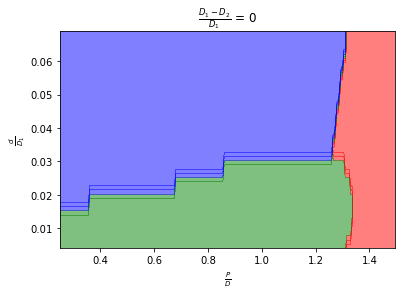

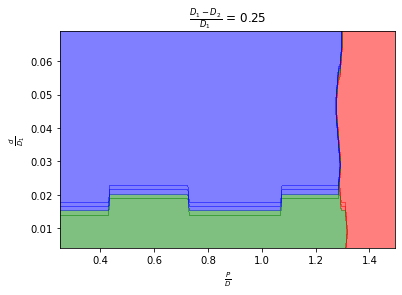

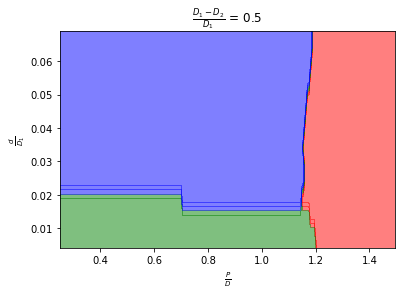

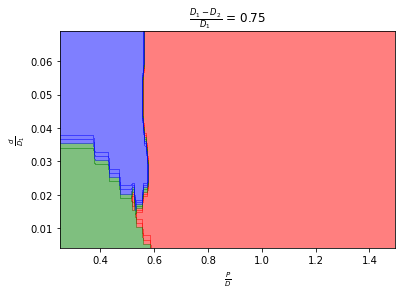

In [10]:
plot_variables = ['ratio_pitch', 'ratio_d', 'ratio_top_diameter']
plot_labels = ['$\\frac{P}{D}$', '$\\frac{d}{D_1}$', '$\\frac{D_1 - D_2}{D_1}$']
for x3 in [0., 0.25, 0.5, 0.75]:
    make_clf_plot(scaler, clf, plot_variables, x3, plot_labels)

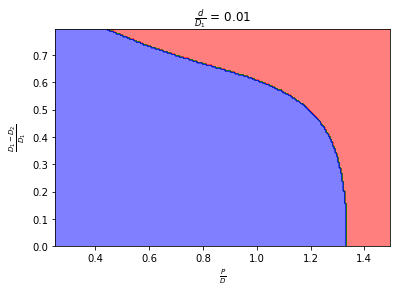

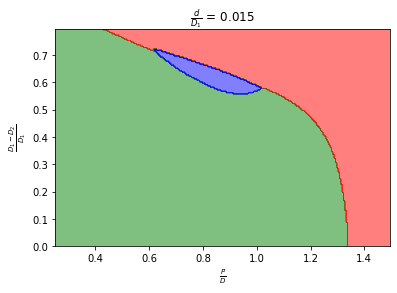

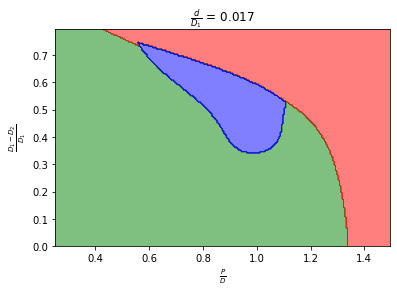

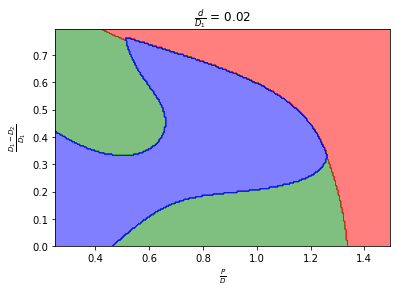

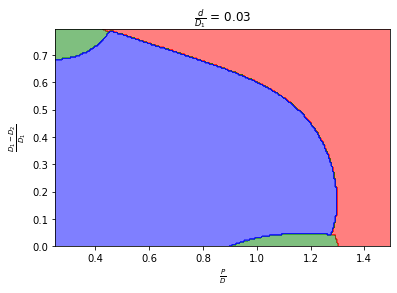

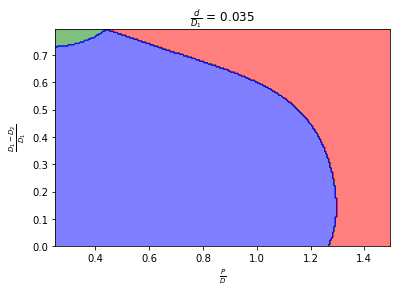

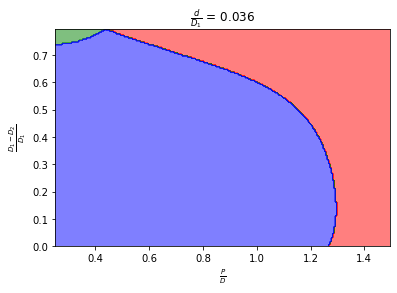

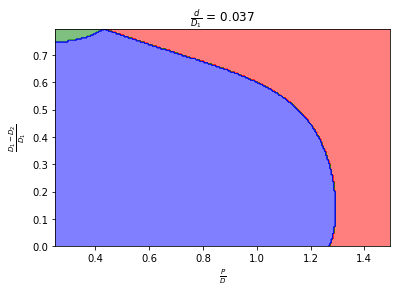

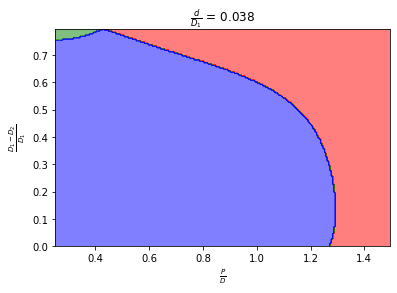

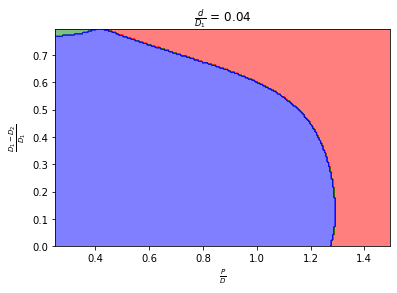

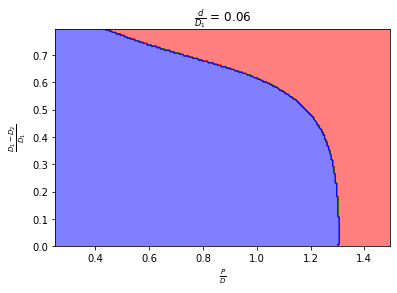

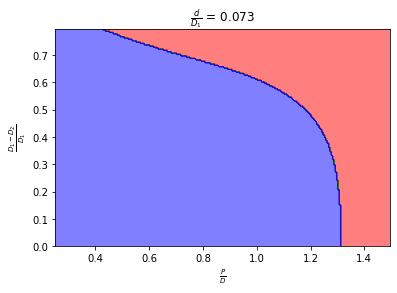

In [11]:
plot_variables = ['ratio_pitch', 'ratio_top_diameter', 'ratio_d']
plot_labels = ['$\\frac{P}{D}$', '$\\frac{D_1 - D_2}{D_1}$', '$\\frac{d}{D_1}$']
for x3 in [0.01, 0.015, 0.017, 0.02, 0.03, 0.035, 0.036, 0.037, 0.038, 0.04, 0.06, 0.073]:
    make_clf_plot(scaler, clf, plot_variables, x3, plot_labels)

Let's make predictions for given points.

In [12]:
xx = [[0.04276196, 0.41448975, 0.69628906], # best in full dataset
      [0.03954443, 0.51306152, 0.65351563],  # best in full dataset (N=3000)
      [0.0337832, 0.32080078, 0.7578125],  # best in full dataset (N=1000)
      [0.03710181, 0.26312256, 0.77441406], # best in the dataset after classification with N=10000
      [0.02876318, 0.31774902, 0.72851562], # best in the dataset after classification with N=5000
      [0.0337832,  0.32080078, 0.7578125], # best in the dataset after classification with N=3000 and N=1000
      [0.04, 0.417, 0.8], # best found after after classification and regression with N=10000
      [0.038, 0.32, 0.8], # best found after after classification and regression with N=5000
      [0.037, 0.32, 0.8], # best found after after classification and regression with N=3000
      [0.037, 0.4, 0.8], # best found after after classification and regression with N=1000
      ]
yy = clf.predict(scaler.transform(xx))

print(yy)

[2. 2. 1. 1. 1. 1. 1. 1. 1. 1.]


And find the maximum energy absorption capable coilable material in the dabase.

In [13]:
# energy values
y_energy = points.loc[:, 'energy'].values.copy()

# predictions for all inputs
yy = clf.predict(scaler.transform(X))

# max energy
indices = np.where((yy == 1) & (~np.isnan(y_energy)))
yy_valid = y_energy[indices]
xx_valid = X[indices]
max_index, max_energy = np.argmax(yy_valid), np.max(yy_valid)

print('Max energy:', max_energy)
print('Corresponding data point:', xx_valid[max_index])

Max energy: 5.057232117087424
Corresponding data point: [0.03710181 0.26312256 0.77441406]


The results are not highly satisfactory. Let's try a different strategy: using a sequential strategy, i.e. start by separate *coilable* from *not coilable* and then, if *coilable* separate between *coilable* and *coilable (but yields)*.

In [14]:
# TODO: implement with pipeline in the future
def make_SVC_sequentially(X_train, y_train, train_size, kernel='rbf'):
    
    class SeqCLF(object):
        
        def __init__(self, clf0, clf1):
            self.clf0 = clf0
            self.clf1 = clf1
        
        
        def predict(self, X):
            
            # predictions from the first classifier
            y = self.clf0.predict(X)
            
            # predictions from the second classifier
            indices = np.where(y>0)
            X_1 = X[indices]
            y_1 = self.clf1.predict(X_1)
            y[indices] = y_1
            
            return y
        
    # transform y data
    y_train_0 = y_train.copy()
    y_train_0[np.where(y_train==2)] = 1
    
    # train first classifier
    clf0 = SVC(kernel=kernel).fit(X_train, y_train_0)
    
    # train second classifier
    indices = np.where(y_train>0)
    X_train_1 = X_train[indices]
    y_train_1 = y_train[indices]
    clf1 = SVC(kernel=kernel).fit(X_train_1, y_train_1)
    
    # create clf
    clf = SeqCLF(clf0, clf1)
    
    return clf

In [15]:
# choose train size
train_size = .8
(X_train, X_test, y_train, y_test) = split_data(X, y, train_size)
n_train = len(X_train)

# scale data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train
clf = make_SVC_sequentially(X_train_scaled, y_train, train_size, kernel='rbf')

# evaluate model
evaluate_model(clf, (X_train_scaled, y_train), (X_test_scaled, y_test));

Train Accuracy classification score for ML model: 0.892625
Test Accuracy classification score for ML model: 0.891


The results are basically the same.

Before trying out different algorithms, let's try to use only two features and separate between *coilable* and *not coilable*. After visualization of the dataset, the features with the most categorization power appear to be ```ratio_top_diameter``` and ```ratio_pitch```.

In [16]:
# combinations
variables = list(points.columns)[:n_inputs]
combinations = list(itertools.combinations(variables, 2))
combinations.append(tuple(variables))

# train models with different features
metrics_ = binary_metrics[:2]
train_size = .8
metric_results = []
for features in combinations:  
    # get data
    X = points.loc[:, features].values.copy()
    y = points.loc[:, var_name].values.copy()
    y[np.where(y==2)] = 1
    
    # choose train size
    (X_train, X_test, y_train, y_test) = split_data(X, y, train_size)
    n_train = len(X_train)

    # scale data
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # train
    clf = SVC(kernel='rbf').fit(X_train_scaled, y_train)

    # evaluate model
    metric_results.append(evaluate_model(clf, (X_train_scaled, y_train), (X_test_scaled, y_test), metrics=metrics_, print_results=False))
    

Feature combinations:
0: ('ratio_d', 'ratio_pitch')
1: ('ratio_d', 'ratio_top_diameter')
2: ('ratio_pitch', 'ratio_top_diameter')
3: ('ratio_d', 'ratio_pitch', 'ratio_top_diameter')


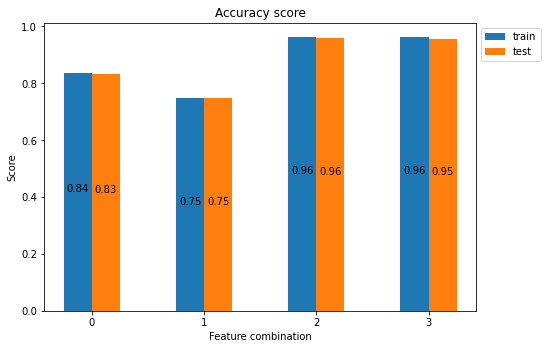

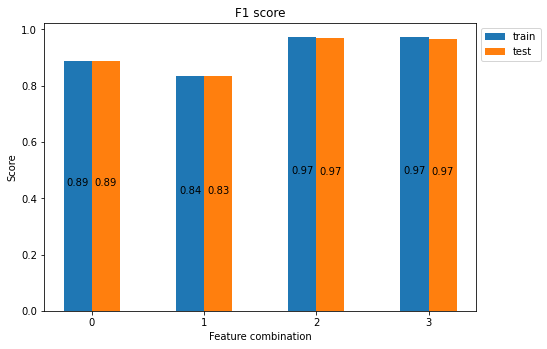

In [17]:
# print information regarding features combinations
print('Feature combinations:')
for i, features in enumerate(combinations):
    print('%i:' %i, features)

# plot metric results
for i, metric in enumerate(metrics_):
    
    # train
    yy_train = [xx_[i][0] for xx_ in metric_results]
    
    # test
    yy_test = [xx_[i][1] for xx_ in metric_results]
    
    width = .25
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    xx = np.arange(len(combinations))
    ax.bar(xx - width/2, yy_train, width=width, label='train')
    ax.bar(xx + width/2, yy_test, width=width, label='test')
    for xx_, v in zip(xx, yy_train):
        plt.text(xx_ - width/2, v/2, '%.2f' % v, horizontalalignment='center')
    for xx_, v in zip(xx, yy_test):
        plt.text(xx_ + width/2, v/2, '%.2f' % v, horizontalalignment='center')
    ax.set_title(metric[1])
    ax.set_xlabel('Feature combination')
    ax.set_ylabel('Score')
    ax.legend()
    ax.set_xticks(xx)
    ax.legend(bbox_to_anchor=(1, 1))

Let's now try out a different classifier.

In [18]:
# get X data
X = points.iloc[:,range(n_inputs)].values.copy()

# get y data
y = points.loc[:, 'coilable'].values.copy()
for yy in np.unique(y):
    print('Class %i: %i' % (int(yy), np.sum(y==yy)))
    

Class 0: 3174
Class 1: 2013
Class 2: 4813


In [19]:
# choose train size
train_size = .8
(X_train, X_test, y_train, y_test) = split_data(X, y, train_size)
n_train = len(X_train)

# scale data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train
clf = RandomForestClassifier(n_estimators=40, max_depth=7, random_state=1).fit(X_train_scaled, y_train)

# evaluate model
evaluate_model(clf, (X_train_scaled, y_train), (X_test_scaled, y_test));

Train Accuracy classification score for ML model: 0.89525
Test Accuracy classification score for ML model: 0.891


The performance of both algorithms is similar.

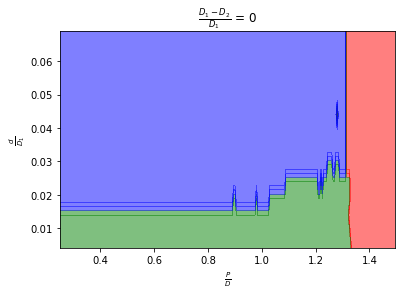

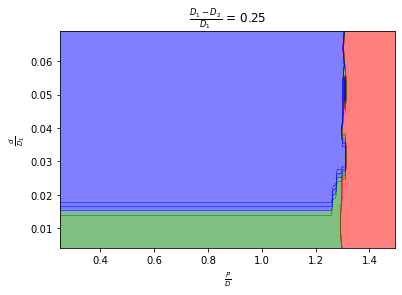

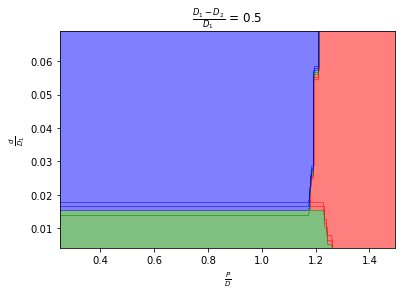

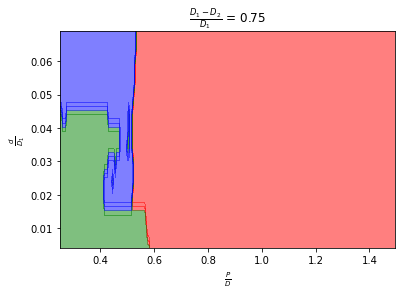

In [20]:
plot_variables = ['ratio_pitch', 'ratio_d', 'ratio_top_diameter']
plot_labels = ['$\\frac{P}{D}$', '$\\frac{d}{D_1}$', '$\\frac{D_1 - D_2}{D_1}$']
for x3 in [0., 0.25, 0.5, 0.75]:
    make_clf_plot(scaler, clf, plot_variables, x3, plot_labels)

Let's change slightly the representation.

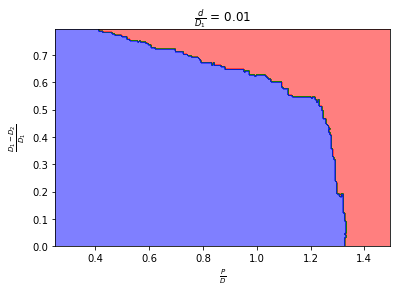

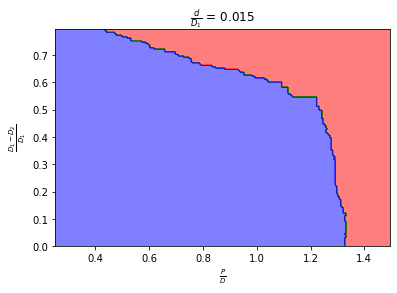

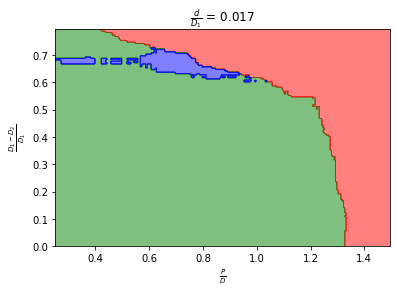

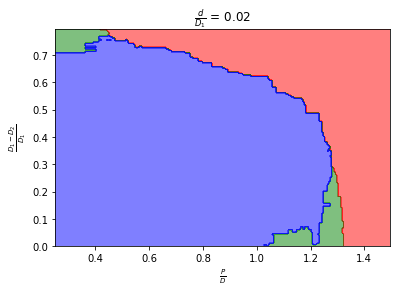

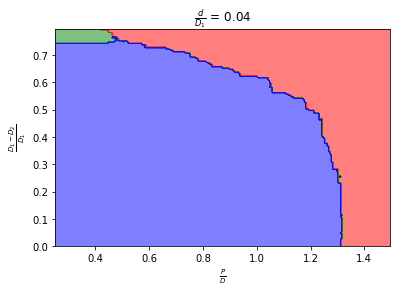

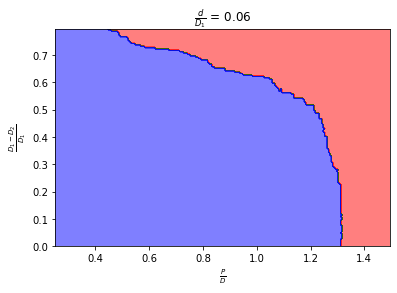

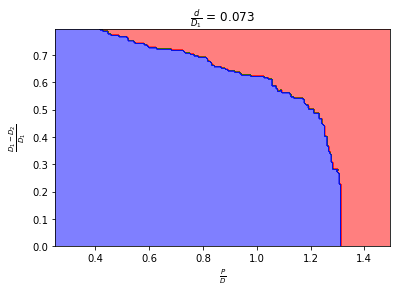

In [21]:
plot_variables = ['ratio_pitch', 'ratio_top_diameter', 'ratio_d']
plot_labels = ['$\\frac{P}{D}$', '$\\frac{D_1 - D_2}{D_1}$', '$\\frac{d}{D_1}$']
for x3 in [0.01, 0.015, 0.017, 0.02, 0.04, 0.06, 0.073]:
    make_clf_plot(scaler, clf, plot_variables, x3, plot_labels)